In [2]:
# Necessary Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

<p style="text-align:center; font-size:x-large; color:black;">De-Trending and De-Seasonalizing ERCOT Hourly Demand</p>
<hr>

After using Selenium to extract the necessary information from ERCOT's website, we can just use Pandas to read the CSV file that we have created.

In [3]:
df = pd.read_csv('HourlyERCOTData.csv', header = 0)
df['DateTime'] = pd.to_datetime(df['DateTime'], format = "ISO8601")
df.index = [i/(365.25 * 24) for i in range(len(df.index))]  # Useful for when we want to express something as function of time (in years)
df

,DateTime,Coast,East,Far West,North,North Central,South,South Central,West,ERCOT,Date,Hour Ending
0.000000,2002-01-01 00:59:59.003,8331.469266,1111.096549,1094.045496,995.298392,10336.304899,2165.007571,4793.193560,843.747177,29670.162911,2002-01-01,1
0.000114,2002-01-01 01:59:58.997,8107.805431,1091.481584,1083.517981,981.195477,10178.052738,2092.374118,4766.918187,835.488188,29136.833703,2002-01-01,2
0.000228,2002-01-01 02:59:59.000,7890.721717,1080.257616,1085.038740,971.305257,10100.887710,2042.080714,4702.918892,830.694878,28703.905525,2002-01-01,3
0.000342,2002-01-01 03:59:59.003,7799.817527,1079.726403,1093.381853,971.262963,10081.565109,2011.935791,4669.064391,835.068413,28541.822450,2002-01-01,4
0.000456,2002-01-01 04:59:58.997,7815.968171,1087.934961,1106.651296,982.535591,10192.218670,2002.487678,4695.011904,848.598209,28731.406478,2002-01-01,5
...,...,...,...,...,...,...,...,...,...,...,...,...
22.247091,2024-03-31 19:59:59.000,12861.538998,1606.001310,6369.117950,1194.385911,12596.268392,4204.039428,7913.461050,1300.901689,48045.714727,2024-03-31,20
22.247205,2024-03-31 20:59:59.000,13008.863337,1620.109978,6401.703793,1229.065085,13002.992588,4218.623012,8089.728213,1317.653223,48888.739229,2024-03-31,21
22.247319,2024-03-31 21:59:59.000,12948.139007,1587.879065,6356.533465,1219.858492,12843.154987,4187.083354,7962.281681,1296.010360,48400.940411,2024-03-31,22
22.247433,2024-03-31 22:59:59.000,12552.698541,1481.072355,6323.245205,1177.297905,12230.101142,4057.512091,7604.930665,1240.800077,46667.657982,2024-03-31,23


Before doing any extra computation, I realized there are some rows with missing information.

In [4]:
df[df.isnull().any(axis=1)]

,DateTime,Coast,East,Far West,North,North Central,South,South Central,West,ERCOT,Date,Hour Ending
14.849989,2016-11-06 23:59:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-11-06,24


In [4]:
df = df.dropna()

<p style="text-align:left; font-size:x-large; color:black;"> De-Trending </p>

For any time series, we can choose two types of decomposition methods, __Additive Decomposition__ and __Multiplicative Decomposition__.
$$
\text{Additive Decomposition} = \text{Trend} + \text{Seasonal} + \text{Residuals}
$$
$$
\text{Multiplicative Decomposition} = \text{Trend} * \text{Seasonal} * \text{Residuals}
$$
- A time series' __trend__ component is the smooth, general pattern that captures the underlying behavior of the data. <br>
- A time series' __seasonal__ component represents the predictable fluctuations that occur at fixed intervals, such as daily, or yearly fluctuation. <br>
- Finally, the __residual__ component is what is what is unxeplained by the trend and seasonal components. <br><br>

To visualize the trend in hourly ERCOT demand, we can use a 1-year rolling average  

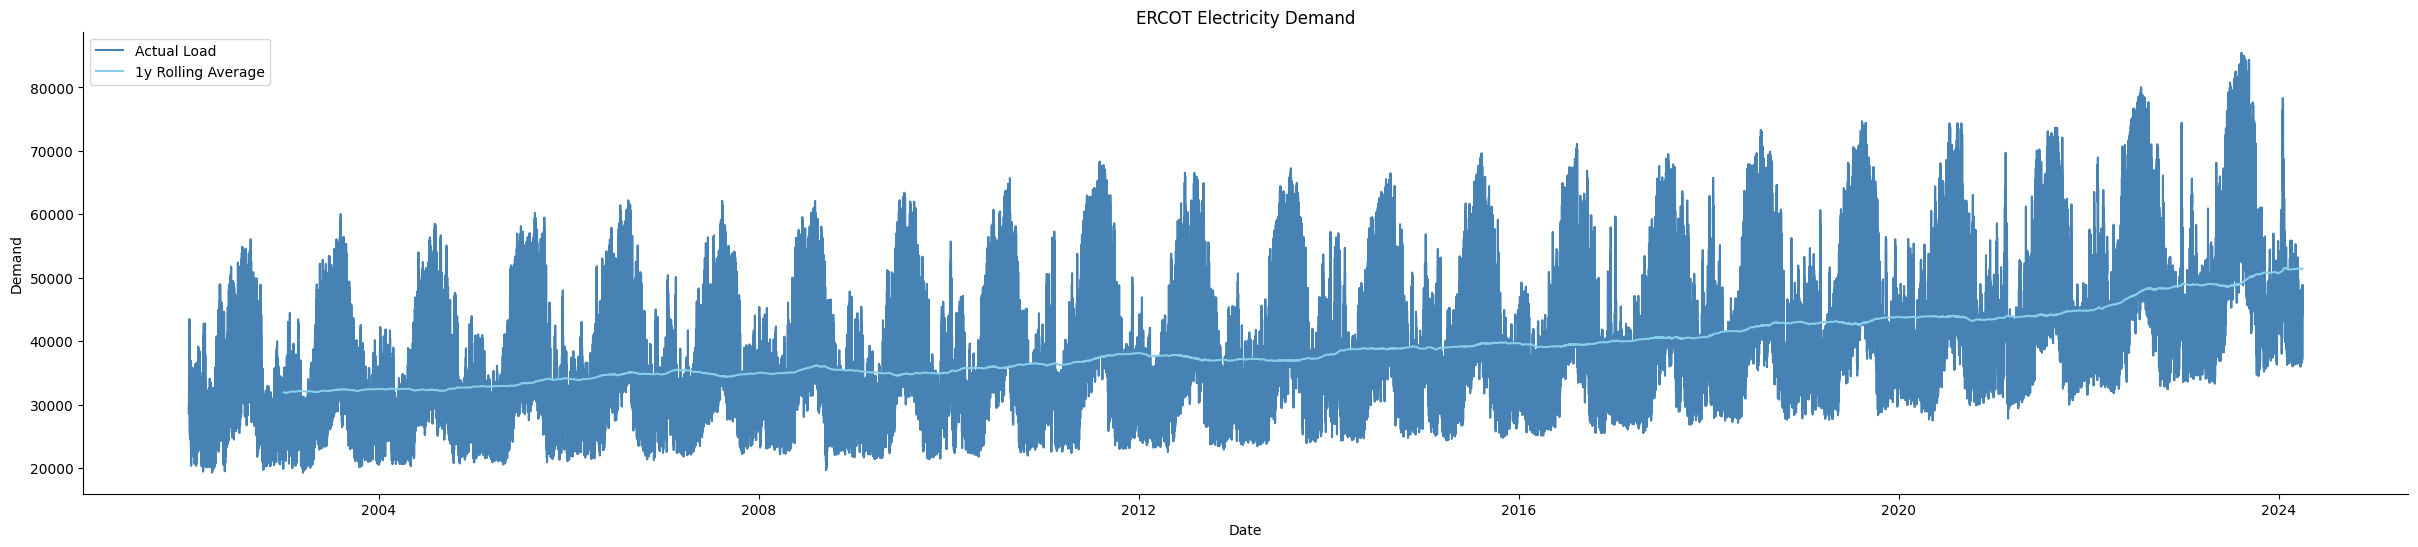

In [5]:
fig = plt.figure(figsize = (30,6))
plt.plot(df['DateTime'], df['ERCOT'], color = 'steelblue', label = 'Actual Load')
plt.plot(df['DateTime'], df['ERCOT'].rolling(window = int(365.25 * 24)).mean(), color = 'skyblue', label = '1y Rolling Average')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title('ERCOT Electricity Demand')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.show()

This looks approximately linear, so I am going to use statsmodel's OLS method to fit a Linear Regression.

In [6]:
training_data = df.loc[0:int(len(df) * 0.8)]
holdout_data = df.loc[int(len(df) * 0.8):]

linear_trend = sm.OLS(training_data['ERCOT'], sm.add_constant(training_data.index)).fit()
print(linear_trend.summary())

                            OLS Regression Results                            
Dep. Variable:                  ERCOT   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                 5.758e+04
Date:                Thu, 18 Apr 2024   Prob (F-statistic):               0.00
Time:                        23:08:42   Log-Likelihood:            -2.0549e+06
No. Observations:              195022   AIC:                         4.110e+06
Df Residuals:                  195020   BIC:                         4.110e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.037e+04     41.286    735.620      0.0

From the statsmodels summary, we notice that a linear model sufficiently captures the long-term trend in the data. From here, we can __de-trend__ the time-series to focus on the seaonal and residual components. <br>
To de-trend our data, we can simply keep the residuals of our linear model.

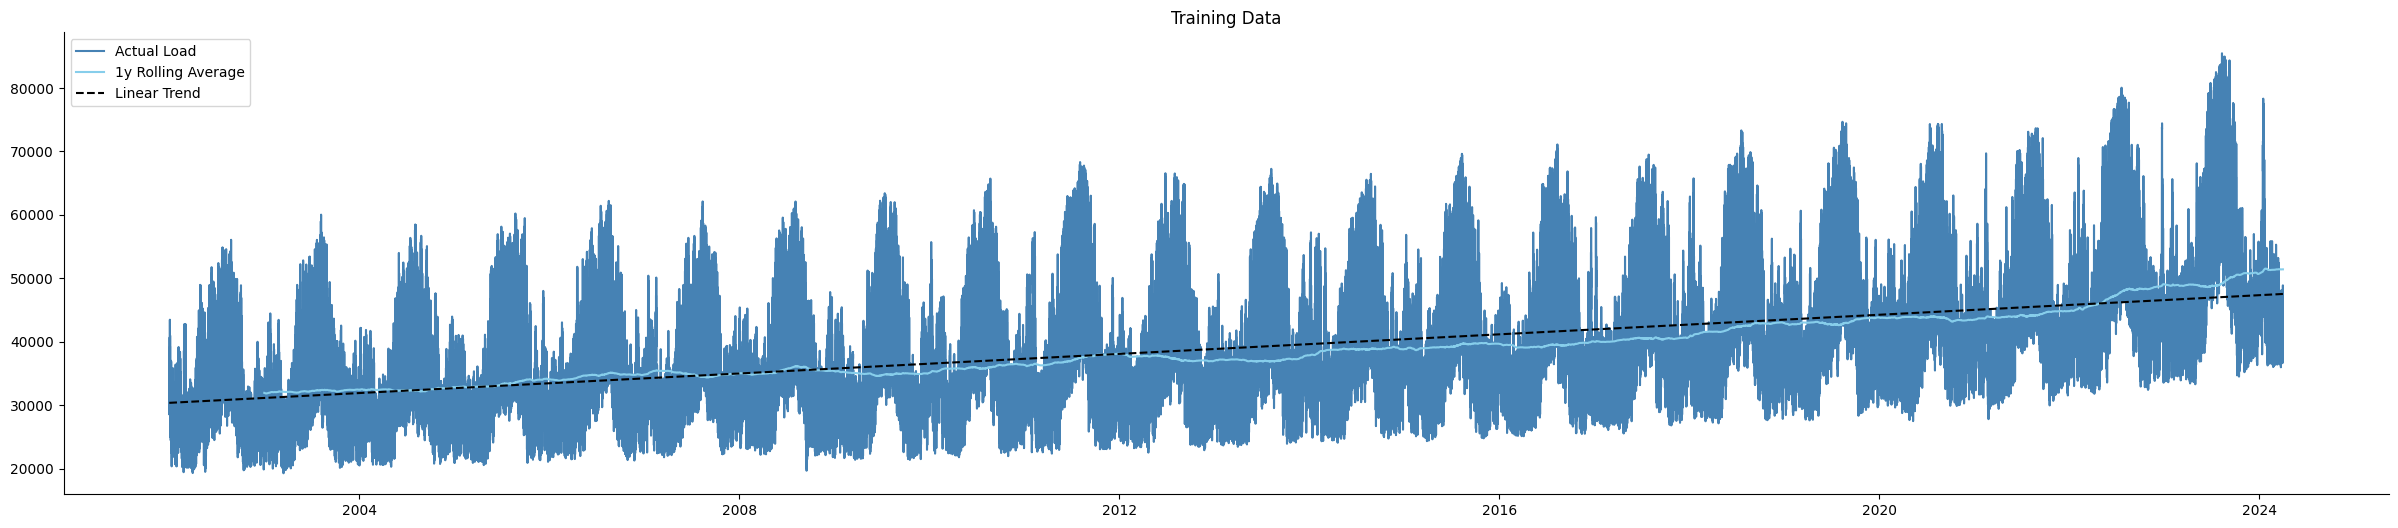

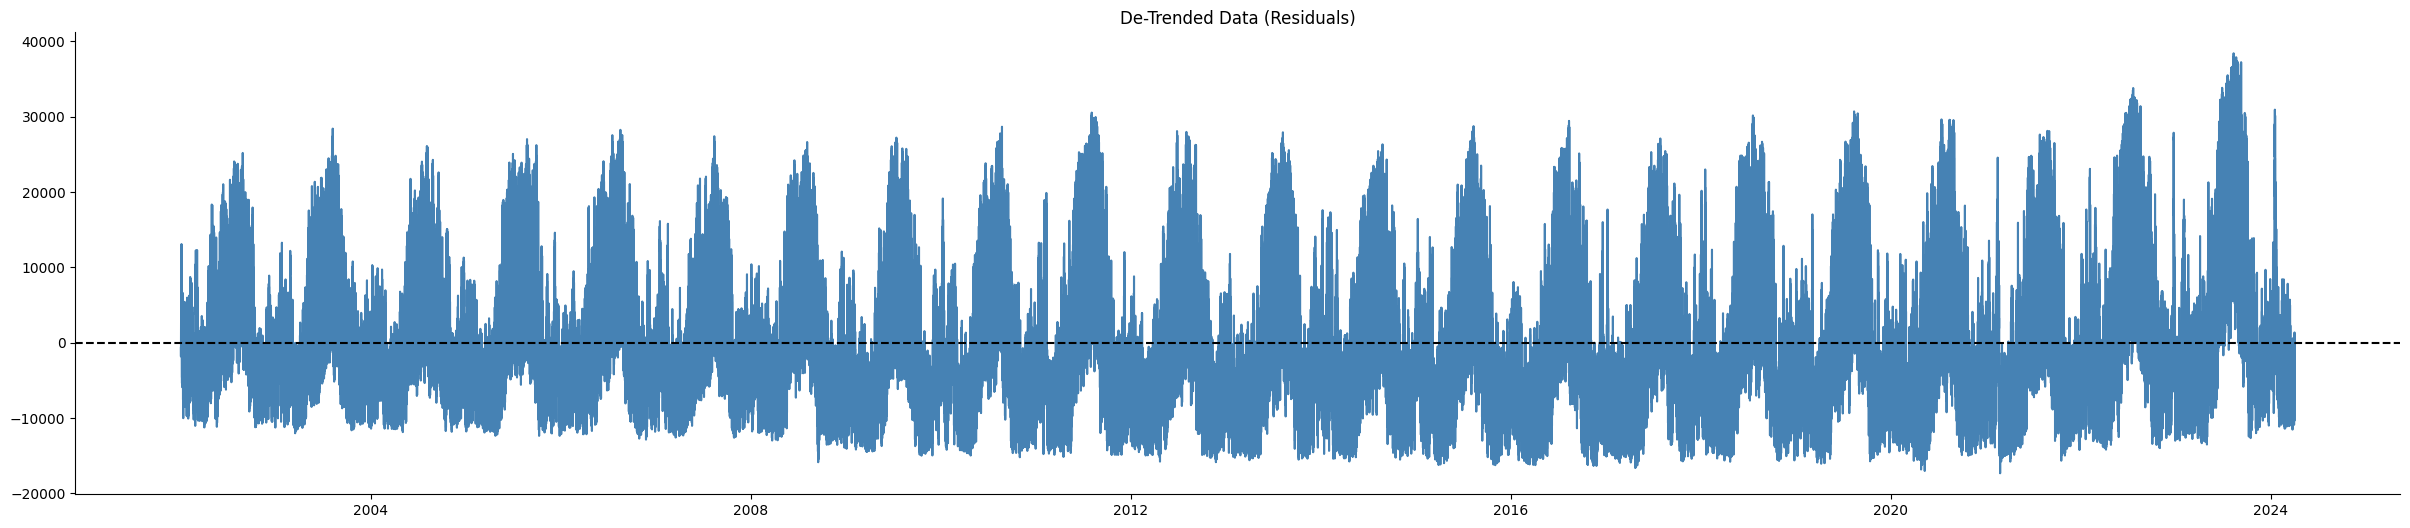

In [8]:
fig = plt.figure(figsize = (30,6))
plt.plot(training_data['DateTime'], training_data['ERCOT'], color = 'steelblue', label = 'Actual Load')
plt.plot(training_data['DateTime'], training_data['ERCOT'].rolling(window = 8766).mean(), color = 'skyblue', label = '1y Rolling Average')
plt.plot(training_data['DateTime'], linear_trend.predict(sm.add_constant(training_data.index)), color = 'black', linestyle = '--', label = 'Linear Trend')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title('Training Data')
plt.legend()
plt.show()

training_data.loc[:, 'De-Trended'] = linear_trend.resid

fig = plt.figure(figsize = (30,6))
plt.plot(training_data['DateTime'], training_data['De-Trended'], color = 'steelblue')
plt.axhline(y = 0, linestyle = '--', color = 'black')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title('De-Trended Data (Residuals)')
plt.show()

<p style="text-align:left; font-size:x-large; color:black;"> De-Seasonalizing </p>

As stated, the seasonal component represents the predictable fluctuations that occur at fixed intervals, such as daily, or yearly fluctuation. This becomes a much harder task when multiple seasonalities are present, as there are in electricity demand.
- __Causes of Daily Seasonality__:
- __Causes of Weekly Seasonality__:
- __Causes of Yearly Seasonality__:

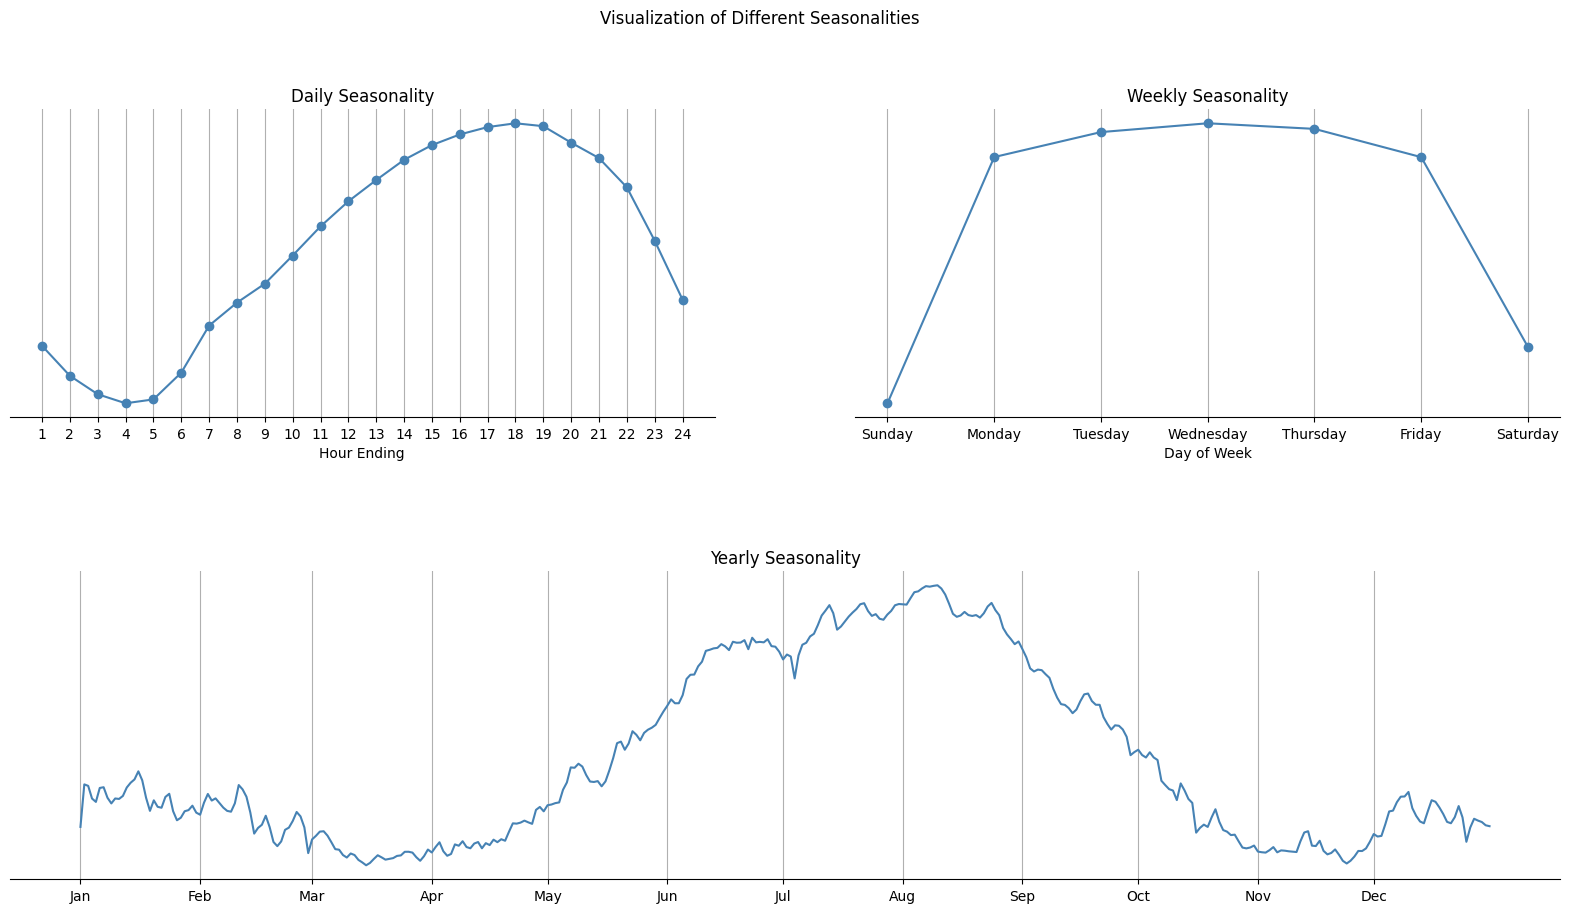

In [9]:
temp_data = training_data.copy()
temp_data['Day'] = temp_data['DateTime'].dt.day
temp_data['Month'] = temp_data['DateTime'].dt.month
temp_data['Day of Week'] = temp_data['DateTime'].dt.day_name()

mean_day = temp_data.groupby('Hour Ending')['De-Trended'].mean().reset_index()

mean_week = temp_data.groupby('Day of Week')['De-Trended'].mean().reset_index()
custom_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
mean_week = mean_week.sort_values(by = 'Day of Week', key = lambda x: x.map({name: i for i, name in enumerate(custom_order)}))

mean_year = temp_data.groupby(['Day', 'Month'])['De-Trended'].mean().reset_index()
mean_year['custom_date'] = pd.to_datetime(mean_year[['Month', 'Day']].assign(year = 2000))
mean_year = mean_year.sort_values(by = 'custom_date', ascending = True)

fig= plt.figure(figsize = (20,10))

ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan = 2)

ax1.plot(mean_day['Hour Ending'], mean_day['De-Trended'], marker = 'o', color = 'steelblue')
ax1.set_title('Daily Seasonality')
ax1.set_xlabel('Hour Ending')
ax1.set_xticks(range(1, 25))
ax1.grid(True)
ax1.spines[['right', 'top', 'left']].set_visible(False)
ax1.set_yticks([])

ax2.plot(mean_week['Day of Week'], mean_week['De-Trended'], marker = 'o', color = 'steelblue')
ax2.set_title('Weekly Seasonality')
ax2.grid(True)
ax2.spines[['right', 'top', 'left']].set_visible(False)
ax2.set_xlabel('Day of Week')
ax2.set_yticks([])

ax3.plot(mean_year['custom_date'], mean_year['De-Trended'], color = 'steelblue')
ax3.set_title('Yearly Seasonality')
ax3.grid(True)
ax3.spines[['right', 'top', 'left']].set_visible(False)
ax3.set_yticks([])
ax3.set_xticks(pd.date_range(start = '2000-01-01', end='2000-12-31', freq = 'MS'))
ax3.set_xticklabels([x.strftime('%b') for x in pd.date_range(start='2000-01-01', end='2000-12-31', freq='MS')])

plt.subplots_adjust(hspace=0.5)
plt.suptitle('Visualization of Different Seasonalities')
plt.show()


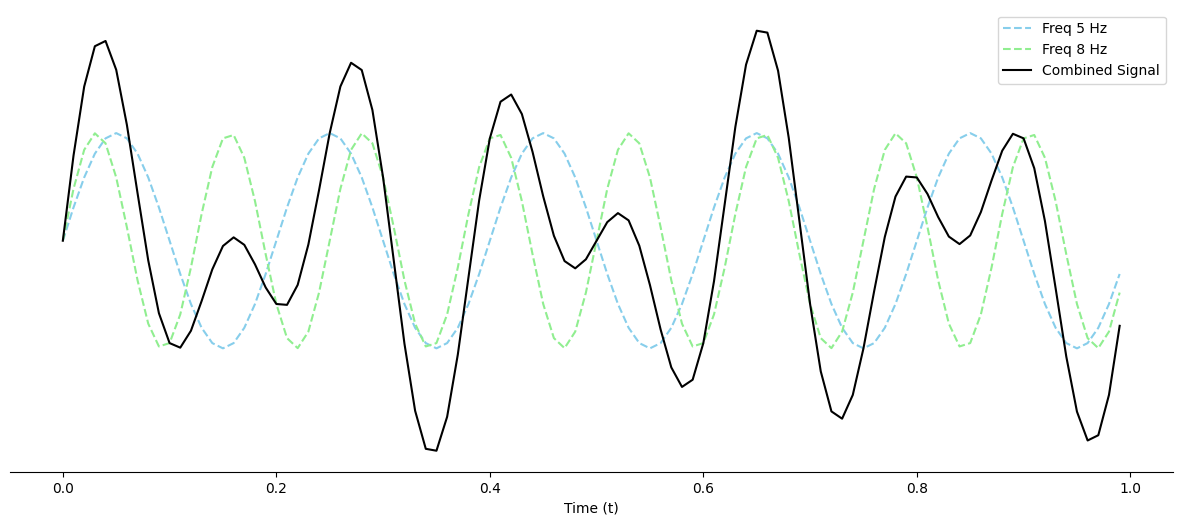

In [10]:
t = np.arange(0, 1, 0.01)

partial_signal_1 = np.sin(2 * np.pi * 5 * t)
partial_signal_2 = np.sin(2 * np.pi * 8 * t)
signal = partial_signal_1 + partial_signal_2

fig = plt.figure(figsize = (15,6))
plt.plot(t, partial_signal_1, color = 'skyblue', linestyle = '--', label = 'Freq (5Hz)')
plt.plot(t, partial_signal_2, color = 'lightgreen', linestyle = '--', label = 'Freq (8Hz)')
plt.plot(t, signal, color = 'black', label = 'Combined Signal')
plt.gca().spines[['right', 'top', 'left']].set_visible(False)
plt.xlabel('Time (t)')
plt.yticks([])
plt.legend()
plt.show()

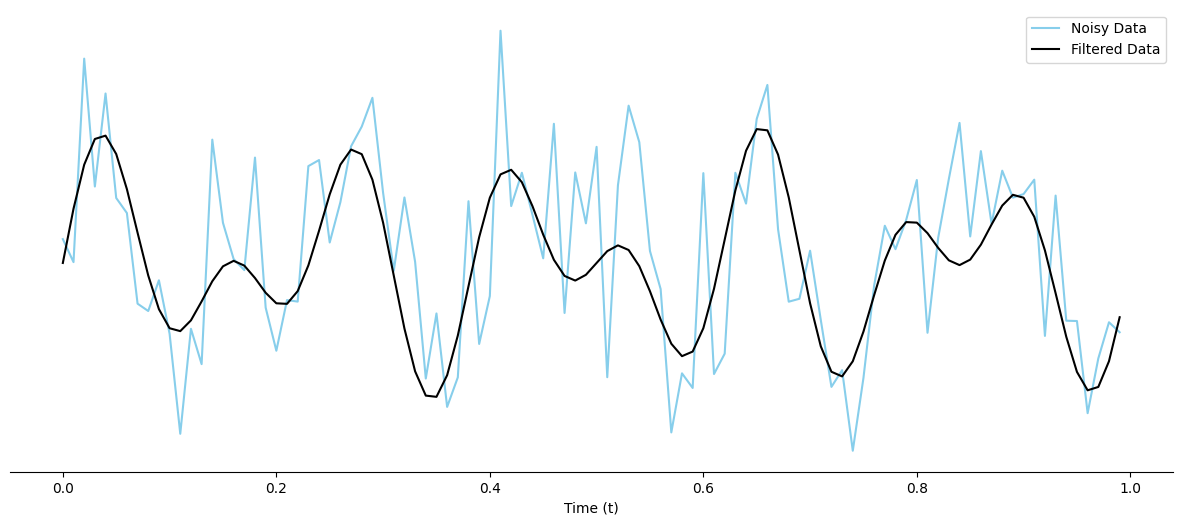

In [12]:
noisy_signal = signal + np.random.normal(loc = 0, scale = 1, size = len(t))

fig = plt.figure(figsize = (15,6))
plt.plot(t, noisy_signal, color = 'skyblue', label = 'Noisy Data')
plt.plot(t, signal, color = 'black', label = 'Filtered Data')
plt.gca().spines[['right', 'top', 'left']].set_visible(False)
plt.xlabel('Time (t)')
plt.yticks([])
plt.legend()
plt.show()

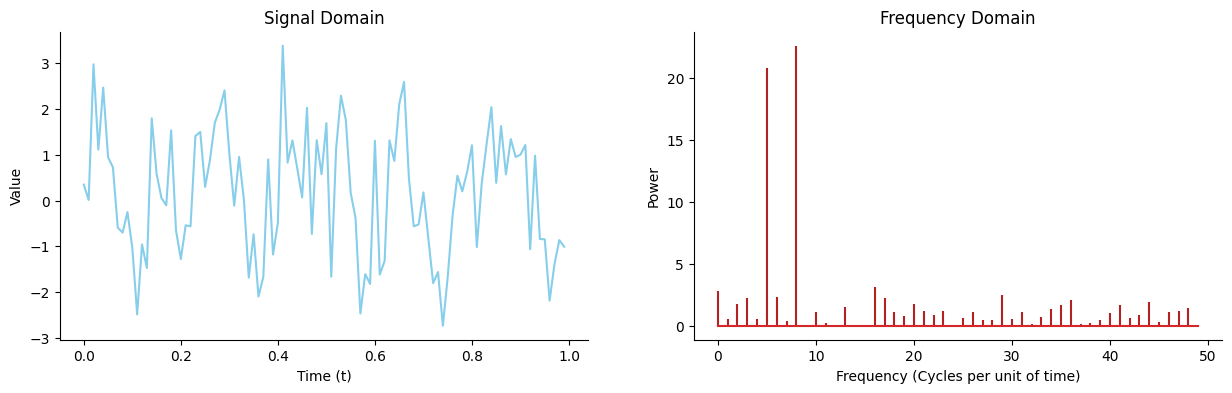

In [36]:
# Fourier Analysis.

fft_on_noise = np.fft.fft(noisy_signal)
PSD = np.real(fft_on_noise * np.conj(fft_on_noise)) / len(fft_on_noise)
frequency_bins = np.fft.fftfreq(n = len(t), d = 0.01)

fig, axs = plt.subplots(1,2, figsize = (15,4))
axs[0].plot(t, noisy_signal, color = 'skyblue')
axs[0].spines[['right', 'top']].set_visible(False)
axs[0].set_xlabel('Time (t)')
axs[0].set_ylabel('Value')
axs[0].set_title('Signal Domain')

axs[1].stem(frequency_bins[:len(frequency_bins) // 2], PSD[:len(PSD) // 2], markerfmt = '', linefmt = 'firebrick')
axs[1].spines[['right', 'top']].set_visible(False)
axs[1].set_title('Frequency Domain')
axs[1].set_xlabel('Frequency (Cycles per unit of time)')
axs[1].set_ylabel('Power')
plt.show()

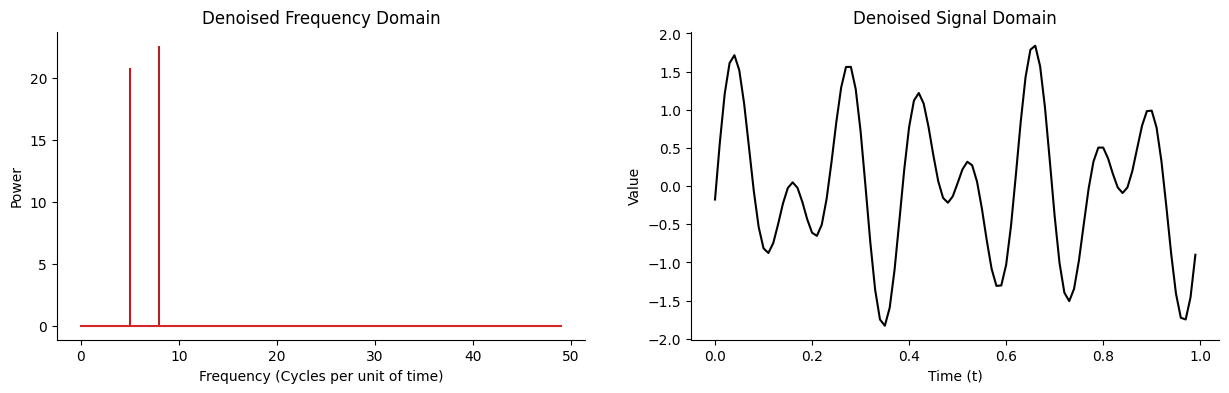

In [38]:
denoised_fft = fft_on_noise
denoised_PSD = PSD
for i in range(len(PSD)):
    if PSD[i] < 20:
        denoised_PSD[i] = 0
        denoised_fft[i] = 0

denoised_signal = np.real(np.fft.ifft(denoised_fft))

fig, axs = plt.subplots(1,2, figsize = (15,4))
axs[0].stem(frequency_bins[:len(frequency_bins) // 2], denoised_PSD[:len(denoised_PSD) // 2], markerfmt = '', linefmt = 'firebrick')
axs[0].spines[['right', 'top']].set_visible(False)
axs[0].set_xlabel('Frequency (Cycles per unit of time)')
axs[0].set_ylabel('Power')
axs[0].set_title('Denoised Frequency Domain')

axs[1].plot(t, denoised_signal, color = 'black')
axs[1].spines[['right', 'top']].set_visible(False)
axs[1].set_xlabel('Time (t)')
axs[1].set_ylabel('Value')
axs[1].set_title('Denoised Signal Domain')
plt.show()

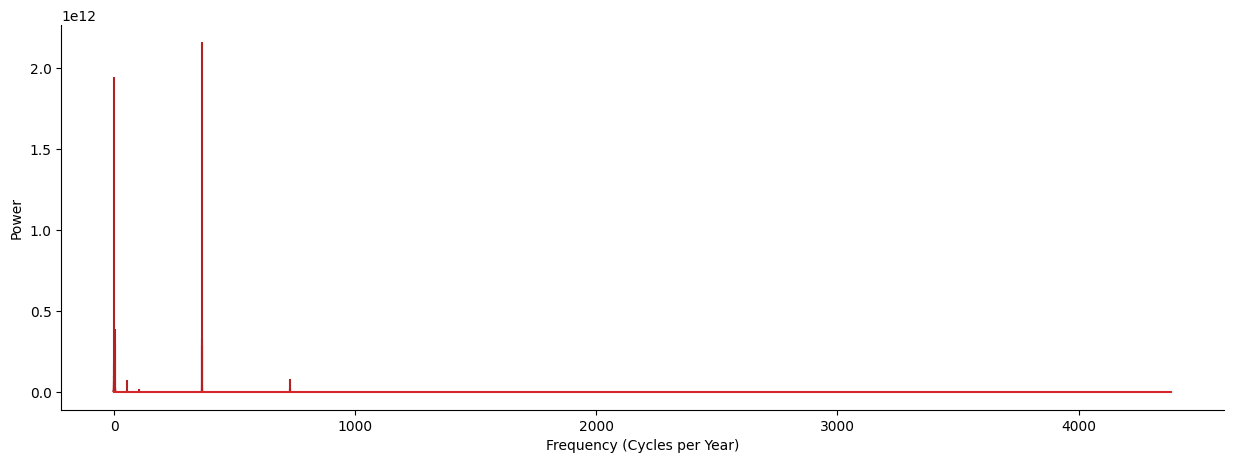

In [40]:
trained_fft = np.fft.fft(training_data['De-Trended'])
PSD = np.real(trained_fft * np.conj(trained_fft)) / len(trained_fft)
freqs = np.fft.fftfreq(n = len(training_data['De-Trended']), d = 1/(24 * 365.25))

fig = plt.figure(figsize = (15,5))
plt.stem(freqs[:len(freqs) // 2], PSD[:len(PSD) // 2], markerfmt = '', linefmt = 'firebrick')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.xlabel('Frequency (Cycles per Year)')
plt.ylabel('Power')
plt.show()

# Highlighting Yearly and Semi-Yearly Seasonality
# plt.stem(freqs[:100], PSD[:100], markerfmt = '', linefmt = 'firebrick')

# Highlighting Weekly Seasonality
# plt.stem(freqs[900:950], PSD[900:950], markerfmt = '', linefmt = 'firebrick')

# Highlighting Daily Seasonality (365 cycles / year)
# plt.stem(freqs[6450:6550], PSD[6450:6550], markerfmt = '', linefmt = 'firebrick')

# Highlighting Intra-Day Seasonality (730 cycles / year)
# plt.stem(freqs[12900:13100], PSD[12900:13100], markerfmt = '', linefmt = 'firebrick')

# Remodel seasonal component with these


# denoised_fft = trained_fft
# for i in range(len(PSD)):
#     if PSD[i] < 1e9:
#         denoised_fft[i] = 0
# 
# denoised_PSD = np.real(denoised_fft * np.conj(denoised_fft)) / len(denoised_fft)
# 
# fig = plt.figure(figsize = (30,10))
# plt.stem(freqs[:len(freqs) // 2], denoised_PSD[:len(denoised_PSD) // 2], markerfmt = '', linefmt = 'firebrick')
# 
# plt.show()
# 
# denoised_time_series = np.real(np.fft.ifft(denoised_fft))
# fig = plt.figure(figsize = (30,6))
# plt.plot(training_data['DateTime'], linear_trend.resid, linewidth = 1, color = 'steelblue')
# plt.plot(training_data['DateTime'], denoised_time_series, linewidth = 1, color = 'skyblue')
# plt.show()


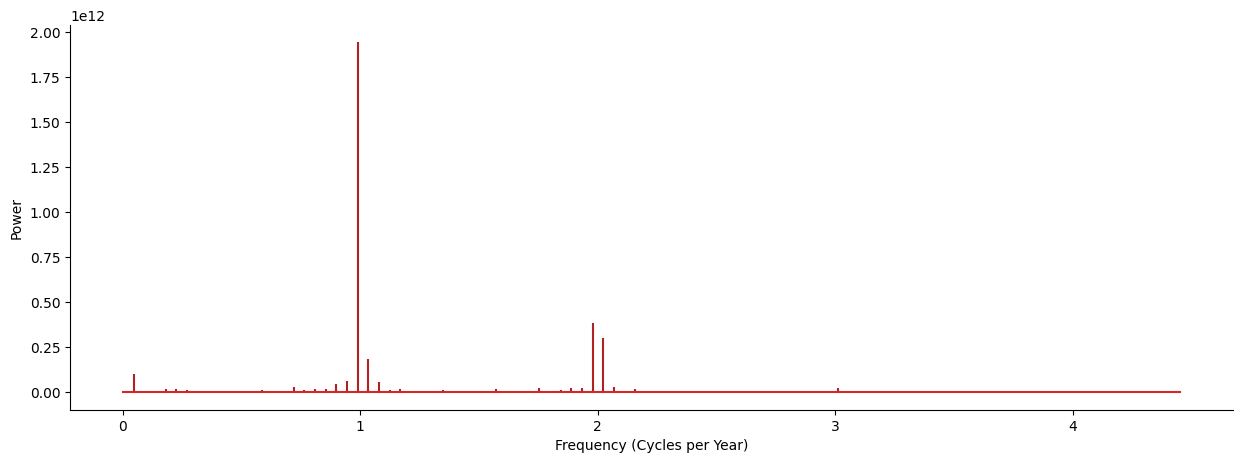

In [41]:
fig = plt.figure(figsize = (15,5))
plt.stem(freqs[:100], PSD[:100], markerfmt = '', linefmt = 'firebrick')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.xlabel('Frequency (Cycles per Year)')
plt.ylabel('Power')
plt.show()

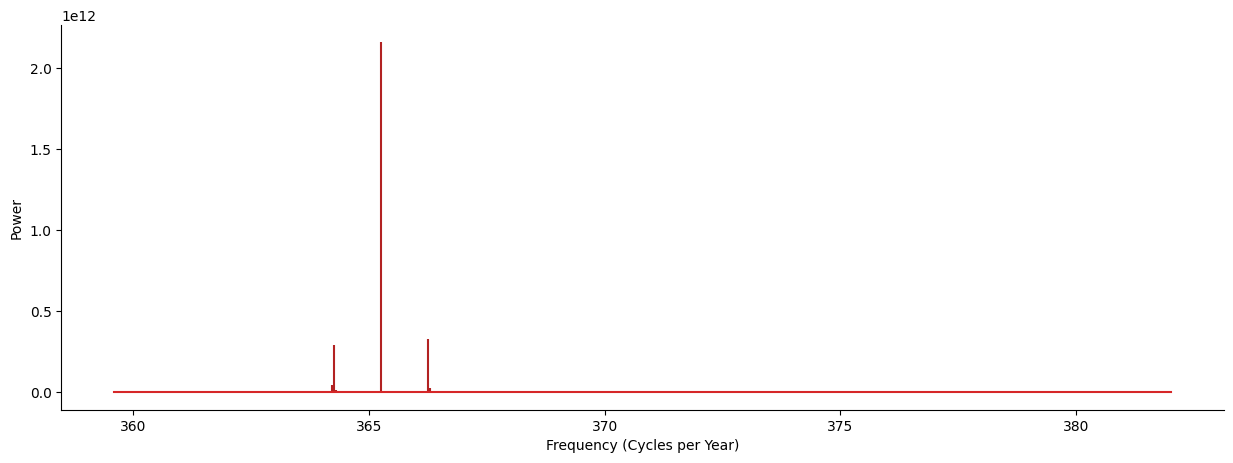

In [50]:
fig = plt.figure(figsize = (15,5))
plt.stem(freqs[8000:8500], PSD[8000:8500], markerfmt = '', linefmt = 'firebrick')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.xlabel('Frequency (Cycles per Year)')
plt.ylabel('Power')
plt.show()

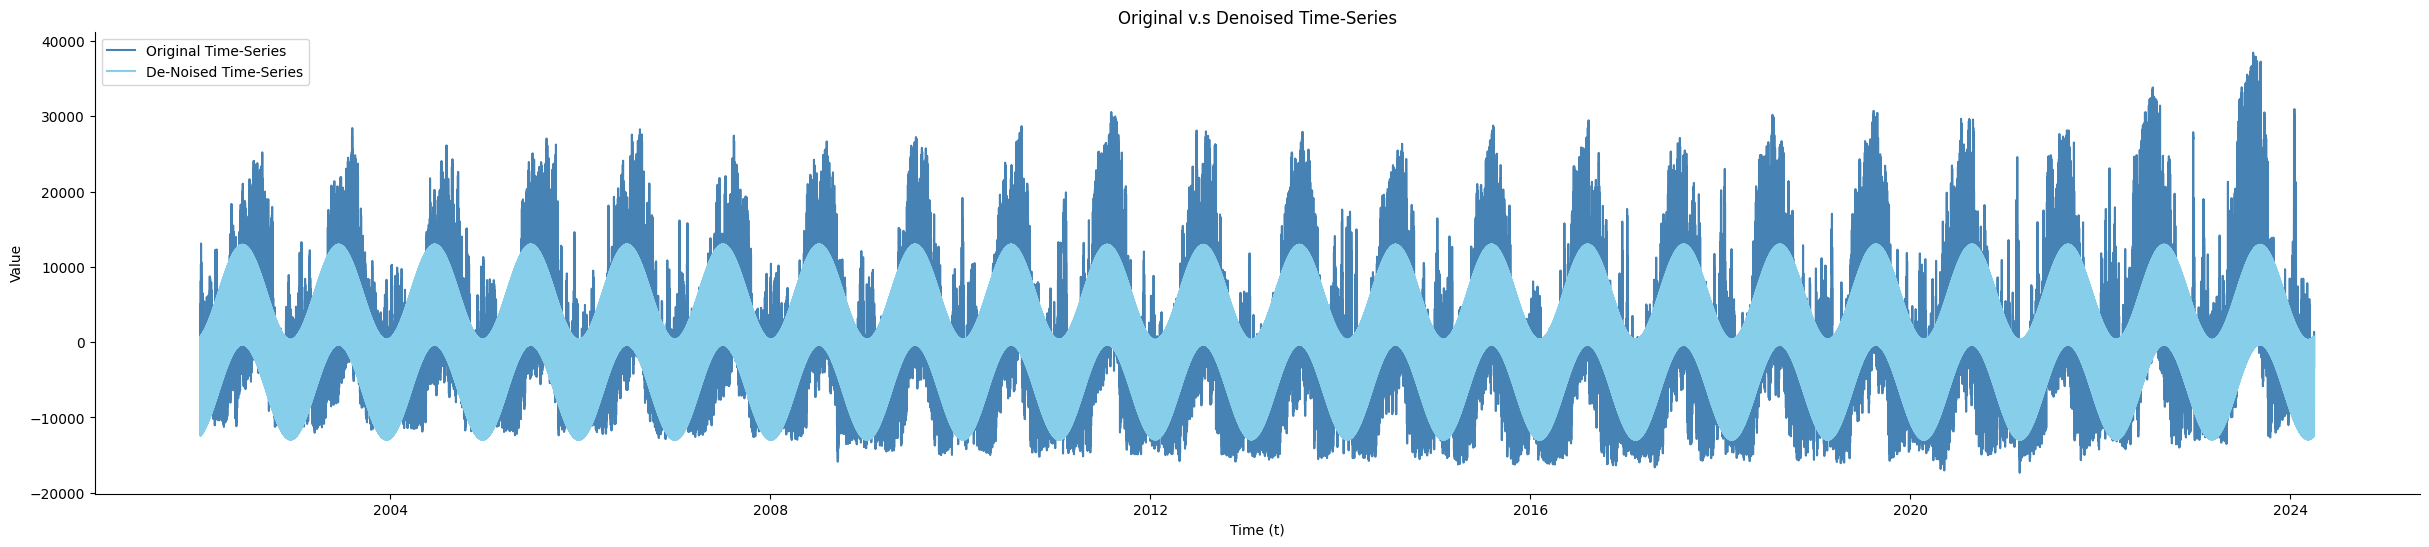

In [65]:
denoised_fft = trained_fft
denoised_PSD = PSD

for i in range(len(PSD)):
    if PSD[i] < 4e11:
        denoised_PSD[i] = 0
        denoised_fft[i] = 0

denoised_signal = np.real(np.fft.ifft(denoised_fft))

fig = plt.figure(figsize = (30 , 6))
plt.plot(training_data['DateTime'], training_data['De-Trended'], color = 'steelblue', label = 'Original Time-Series')
plt.plot(training_data['DateTime'], denoised_signal, color = 'skyblue', label = 'De-Noised Time-Series')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.xlabel('Time (t)')
plt.ylabel('Value')
plt.title('Original v.s Denoised Time-Series')
plt.legend()
plt.show()

In [68]:
trained_fft = np.fft.fft(training_data['De-Trended'])
PSD = np.real(trained_fft * np.conj(trained_fft)) / len(trained_fft)
freqs = np.fft.fftfreq(n = len(training_data['De-Trended']), d = 1/(24 * 365.25))

PSD_data = pd.DataFrame({'Freq':freqs[:len(freqs) // 2],
                         'Power':PSD[:len(PSD) // 2]})
PSD_data = PSD_data.sort_values(by = 'Power', ascending = False)
PSD_data

,Freq,Power
8126,365.253746,2.158433e+12
22,0.988873,1.942635e+12
44,1.977746,3.869351e+11
8148,366.242619,3.265047e+11
45,2.022695,3.020196e+11
...,...,...
92580,4161.357590,6.546850e-01
84153,3782.574263,5.866629e-01
86785,3900.879439,4.923068e-01
57938,2604.242127,9.160748e-02


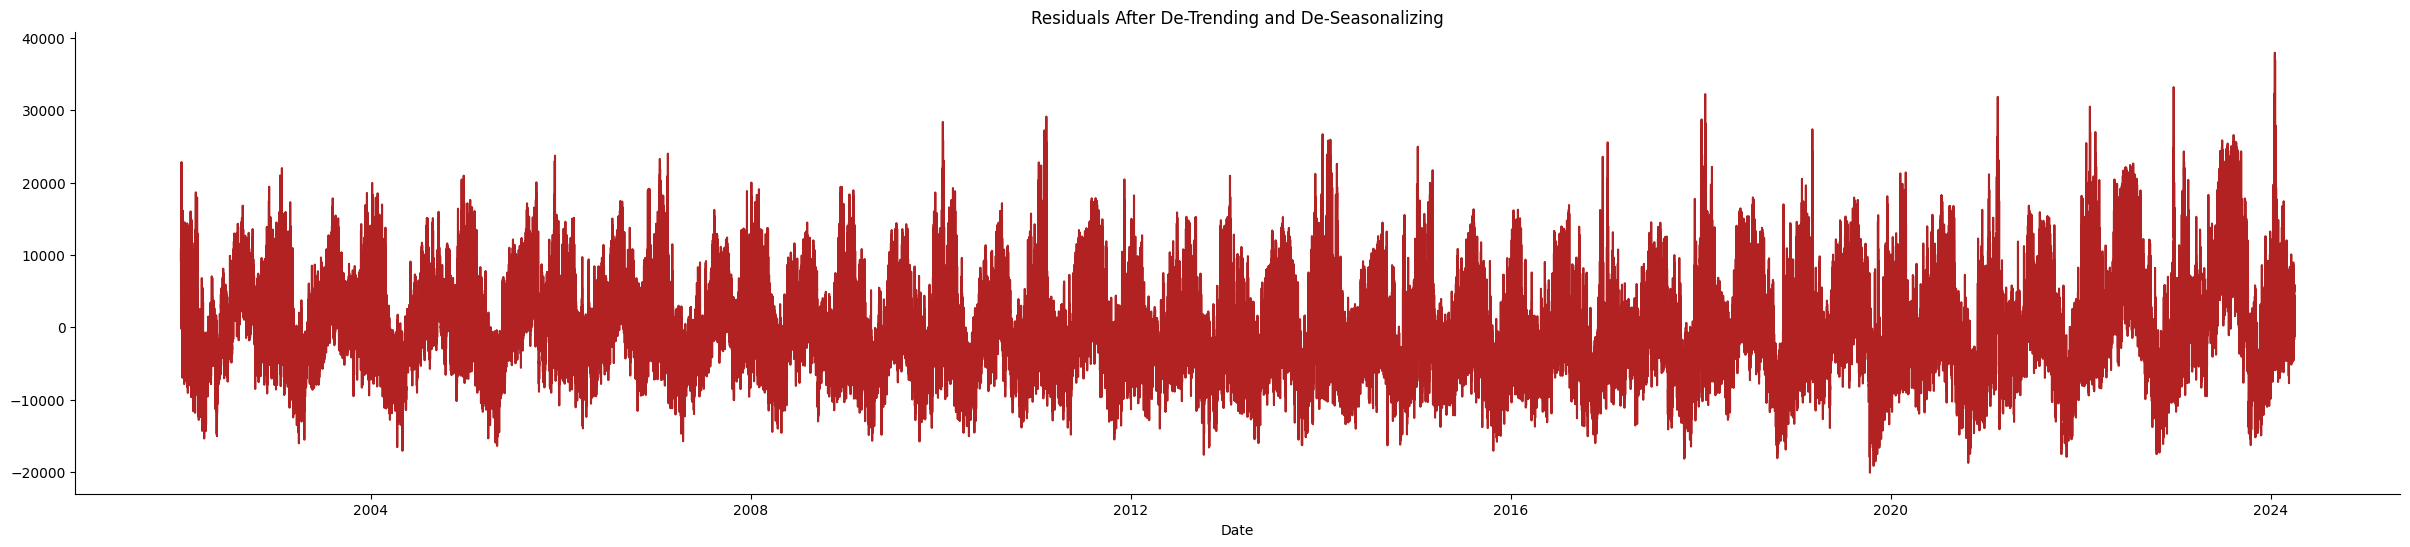

In [75]:
residuals = training_data['De-Trended'] - denoised_signal
fig = plt.figure(figsize = (30,6))
plt.plot(training_data['DateTime'], residuals, color = 'firebrick')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.title('Residuals After De-Trending and De-Seasonalizing')
plt.xlabel('Date')
plt.show()

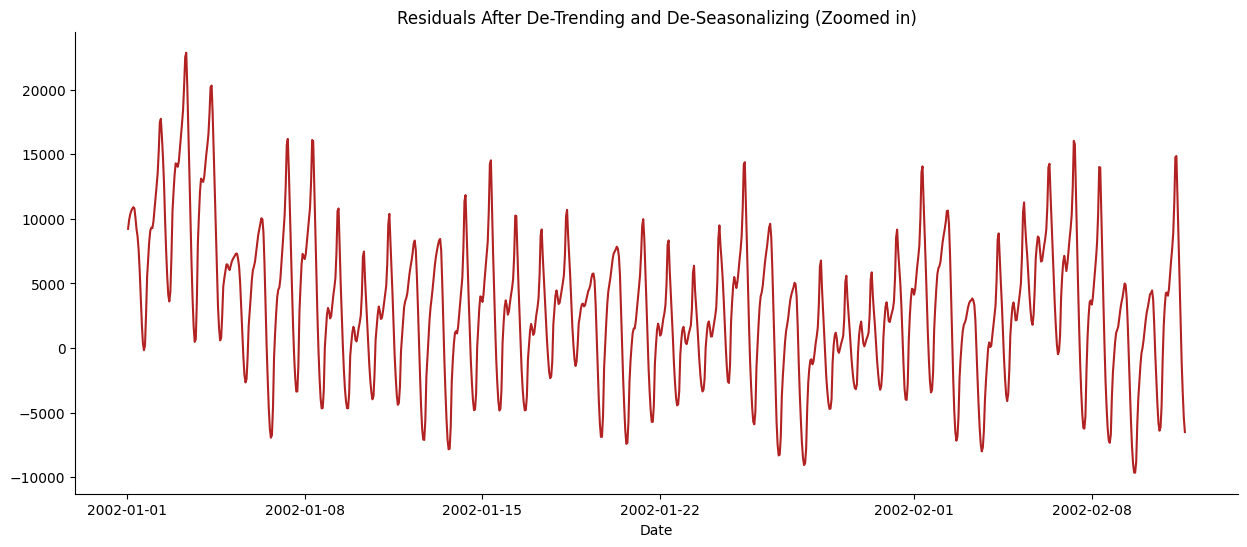

In [83]:
# we only preserved the yearly and daily cycles, so there my still be some underlying pattern in the residuals that the main frequencies didn't account for.
fig = plt.figure(figsize = (15,6))
plt.plot(training_data['DateTime'].iloc[:1000], residuals.iloc[:1000], color = 'firebrick')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.title('Residuals After De-Trending and De-Seasonalizing (Zoomed in)')
plt.xlabel('Date')
plt.show()